In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
from sklearn.utils import class_weight
import glob
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive') # The dataset is saved inside my google drive 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Extracting data in DataFrame format
main_path = '/content/drive/MyDrive/chest_xray'


train_path = os.path.join(main_path,'train')
test_path=os.path.join(main_path,'test')

train_normal = glob.glob(train_path+'/NORMAL/*.jpeg')
train_pneumonia = glob.glob(train_path+'/PNEUMONIA/*.jpeg')

test_normal = glob.glob(test_path+'/NORMAL/*.jpeg')
test_pneumonia = glob.glob(test_path+'/PNEUMONIA/*.jpeg')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [4]:
# Splitting train dataframe to train(90%) and validation(10%)
train_df, val_df = train_test_split(df_train, test_size = 0.1, random_state = 42, stratify = df_train['class'])

In [5]:
print(f'Number of pictures in Validation dataset: {len(val_df)}')
print(f'Number of pictures in Train dataset: {len(train_df)}')

Number of pictures in Validation dataset: 522
Number of pictures in Train dataset: 4694


In [6]:
# Preproccesing data
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             color_mode = 'rgb',
                                             batch_size = batch_size,
                                             shuffle=True,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        shuffle=True,
                                        seed = 42)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        batch_size = 1,
                                        shuffle = False)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print(ds_train.image_shape)

Found 4694 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
(224, 224, 3)


Part1: Class Weigths

In [7]:
df_train.head()

,class,image
0,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL...
1,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL...
2,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL...
3,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL...
4,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL...


In [8]:
num_norm = 0
num_pneu = 0

for index, row in df_train.iterrows():
  if row['class'] == 'Normal':
    num_norm += 1
  else:
    num_pneu += 1

weight_for_0 = num_pneu / (num_norm + num_pneu)
weight_for_1 = num_norm / (num_norm + num_pneu)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


VGG16

In [ ]:
pre_trained_modelVGG = tf.keras.applications.vgg16.VGG16(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_modelVGG.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in pre_trained_modelVGG.layers:
      if layer.name == 'block3_conv1' or layer.name == 'block3_conv2': # for middle layers
        layer.trainable = True
      else:
        layer.trainable = False

In [ ]:
last_layer = pre_trained_modelVGG.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

modelVGG = Model(pre_trained_modelVGG.input, x) 

modelVGG.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs = 15 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

modelVGG.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

historyVGG = modelVGG.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val, class_weight=class_weight)

Epoch 1/15
38/38 [==============================] - 631s 15s/step - loss: 0.1819 - accuracy: 0.7627 - val_loss: 0.2224 - val_accuracy: 0.9330
Epoch 2/15
38/38 [==============================] - 96s 3s/step - loss: 0.0693 - accuracy: 0.9325 - val_loss: 0.1030 - val_accuracy: 0.9655
Epoch 3/15
38/38 [==============================] - 89s 2s/step - loss: 0.0435 - accuracy: 0.9589 - val_loss: 0.1027 - val_accuracy: 0.9674
Epoch 4/15
38/38 [==============================] - 91s 2s/step - loss: 0.0361 - accuracy: 0.9655 - val_loss: 0.0587 - val_accuracy: 0.9751
Epoch 5/15
38/38 [==============================] - 88s 2s/step - loss: 0.0288 - accuracy: 0.9753 - val_loss: 0.0555 - val_accuracy: 0.9751
Epoch 6/15
38/38 [==============================] - 88s 2s/step - loss: 0.0276 - accuracy: 0.9736 - val_loss: 0.0555 - val_accuracy: 0.9770
Epoch 7/15
38/38 [==============================] - 88s 2s/step - loss: 0.0228 - accuracy: 0.9793 - val_loss: 0.0542 - val_accuracy: 0.9770
Epoch 8/15
38/38 [

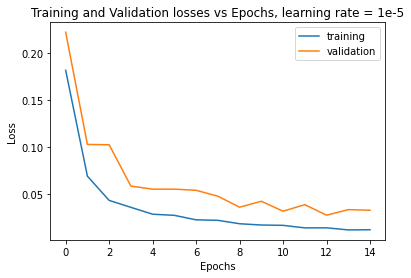

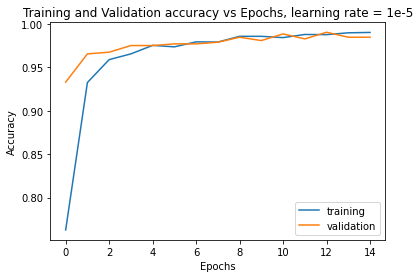

In [ ]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(historyVGG.history['loss'])
plt.plot(historyVGG.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(historyVGG.history['accuracy'])
plt.plot(historyVGG.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = modelVGG.evaluate(ds_test)

624/624 [==============================] - 101s 160ms/step - loss: 0.5768 - accuracy: 0.8157


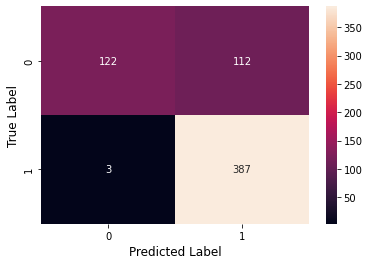

In [ ]:
import seaborn as sns

num_label = {'Normal':0, 'Pneumonia':1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = modelVGG.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [ ]:
print('hello')

hello


In [ ]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.99
Precision score is: 0.78


Resnet50

In [9]:
pre_trained_model_Res = tf.keras.applications.resnet50.ResNet50(input_shape = (224, 224, 3), 
                                include_top = False,
                                weights = 'imagenet')

pre_trained_model_Res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
for layer in pre_trained_model_Res.layers:
      if layer.name == 'conv3_block3_2_conv' or layer.name == 'conv3_block3_3_conv':
        layer.trainable = True
      else:
        layer.trainable = False

In [11]:
x = layers.Flatten()(pre_trained_model_Res.output)
x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Compile
modelRes = tf.keras.Model(pre_trained_model_Res.input, outputs)

modelRes.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
epochs = 30 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

modelRes.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

historyRes = modelRes.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val, class_weight=class_weight)

Epoch 1/30
74/74 [==============================] - 98s 1s/step - loss: 0.2576 - accuracy: 0.6212 - val_loss: 0.5593 - val_accuracy: 0.7969
Epoch 2/30
74/74 [==============================] - 86s 1s/step - loss: 0.1761 - accuracy: 0.8179 - val_loss: 0.3488 - val_accuracy: 0.8889
Epoch 3/30
74/74 [==============================] - 86s 1s/step - loss: 0.1457 - accuracy: 0.8430 - val_loss: 0.2823 - val_accuracy: 0.8985
Epoch 4/30
74/74 [==============================] - 85s 1s/step - loss: 0.1296 - accuracy: 0.8611 - val_loss: 0.2639 - val_accuracy: 0.9004
Epoch 5/30
74/74 [==============================] - 85s 1s/step - loss: 0.1161 - accuracy: 0.8784 - val_loss: 0.3666 - val_accuracy: 0.8544
Epoch 6/30
74/74 [==============================] - 85s 1s/step - loss: 0.1134 - accuracy: 0.8852 - val_loss: 0.3321 - val_accuracy: 0.8678
Epoch 7/30
74/74 [==============================] - 83s 1s/step - loss: 0.1022 - accuracy: 0.8950 - val_loss: 0.1968 - val_accuracy: 0.9291
Epoch 8/30
74/74 [==

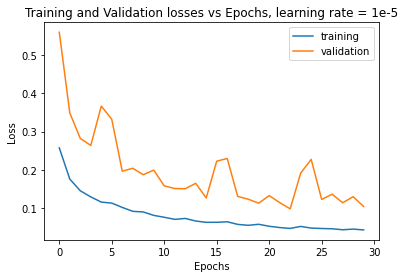

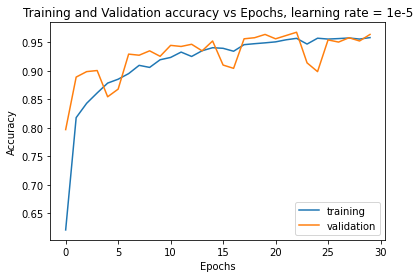

In [18]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(historyRes.history['loss'])
plt.plot(historyRes.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(historyRes.history['accuracy'])
plt.plot(historyRes.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [15]:
test_loss, test_accuracy = modelRes.evaluate(ds_test)

624/624 [==============================] - 25s 39ms/step - loss: 0.5006 - accuracy: 0.7949


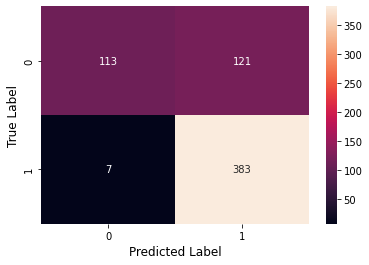

In [16]:
import seaborn as sns

num_label = {'Normal':0, 'Pneumonia':1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = modelRes.predict(ds_test,steps=len(ds_test),verbose=0)
pred_labels = np.where(predictions > 0.5, 1,0)

cm = confusion_matrix(Y_test,pred_labels)
sns.heatmap(cm, annot=True, fmt='d')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.show()

In [17]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.98
Precision score is: 0.76


In [12]:
tf.keras.backend.clear_session() # Run cell before __.fit command